# 8_Transfer_Learning

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.data import Dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import EfficientNetB0, efficientnet

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
RANDOM_SEED: int = 42

tf.random.set_seed(RANDOM_SEED)

The following code assumes you have already set up the local processed dataset as demonstrated in the last notebook. You can look at the `5_CNN_(Fingeralphabet).ipynb` sample solution to see how this was done. Here we will just load that dataset in.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE: int = 16

In [ ]:
# Load tensor dataset
train_ds = Dataset.load('../data/processed/train')
val_ds = Dataset.load('../data/processed/val')

# Batching and caching for performance optimization
train_ds: Dataset = (
    train_ds
    .batch(BATCH_SIZE, drop_remainder=True) #batches for prefetching
    .cache() #keeps in RAM for faster fetching, only do this if you have enough RAM
    .prefetch(buffer_size=AUTOTUNE) #speeds up training by pre-loading next batch while training
)
val_ds: Dataset = (
    val_ds
    .batch(BATCH_SIZE*2, drop_remainder=False) #can use larger batches for validation and they don't need to be the same size
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Multi-Part Models

Now that we have several different compontents to our model we can initialize them separately for better organization. The `name` parameter can help keep things organized.

In [ ]:
IMG_SHAPE = (256, 256, 3)

In [ ]:
# --- Image Augmentor ----
data_augmentor = keras.Sequential([
    # Randomized augmentations
    layers.RandomFlip("horizontal", seed=RANDOM_SEED),
    layers.RandomRotation(0.1, seed=RANDOM_SEED),
    layers.RandomContrast(factor=1, seed=RANDOM_SEED),
], name='augmentation_block')

Pretrained models often require specific preprocessing that may be different from the min max scaling we've been doing. Luckily keras also has preprocessors for these models ready to import. We can use a Lambda layer to turn that preprocessing into a keras layer so we can put it inside the pipeline.

In [ ]:
# --- Preprocessor ---
# Preprocessing for EfficientNet architecture
preprocessor = layers.Lambda(efficientnet.preprocess_input, name='preprocessor')

Now we can bring in the pretrained model.

In our case, we just want the model to do the convolutional feature extraction; we'll custom train the classifier to use those features to determine what sign the hands are making. To remove the pretrained classifier from the model so that we can swap in our own we just need to set `include_top=False`.

We also don't want our optimizer to mess with this model, we want to leave the pretraining and just train a classifier at the end. We can freeze the weights in this part of the model by setting trainable to False; that will make sure AdamW doesn't touch it.

(Note: This code will attempt to make request the model weights from tensorflow's API. If you get a **URL fetch failure** you can download the model manually instead. The next code cell shows how to do this.)

In [ ]:
# --- Feature Extractor (also called "The Backbone") ---
feature_extractor = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,  # removes the classifier
    weights='imagenet', # pretrained on the imagenet 1000 class dataset
    name='efficientnet_backbone'
)

# Freeze weights
feature_extractor.trainable = False

If you get a 403 error trying to access it through the API the easiest alternative is to just download the model manually.

You'll have to download the weights as a `.h5` file. You can ask your instructor to post this on the google drive and then download it from there. Don't download it from an untrusted source as it is possible to inject malware into this type of file.

In [ ]:
# --- Feature Extractor (also called "The Backbone") ---
feature_extractor = EfficientNetB0(
    input_shape=IMG_SHAPE,
    include_top=False,  # removes the classifier
    weights='../models/efficientnetb0_notop.h5', # path to downloaded .h5 file
    name='efficientnet_backbone'
)

# Freeze weights
feature_extractor.trainable = False

In [ ]:
# --- Classifier (also called "The Head") ---
classifier = keras.Sequential([

    # Flattening input
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),

    # Dense hidden layer with dropout
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(3, activation='softmax')

], name='classification_head')

In [ ]:
# Combining the modules
model = keras.Sequential([
    layers.Input(shape=IMG_SHAPE),
    data_augmentor, #augmenting before scaling is more efficient
    preprocessor,
    feature_extractor,
    classifier
], name='full_pipeline')

model.summary()

Model: "full_pipeline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_block (Sequential) │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessor (Lambda)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet_backbone           │ (None, 8, 8, 1280)     │     4,049,571 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head             │ (None, 3)              │    10,486,275 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,535,846 (55.45 MB)

 Trainable params: 10,486,275 (40.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Training

In [ ]:
# Initializing early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=5, #number of epochs of no improvement before training is stopped
    restore_best_weights=True #revert weights back to what they were before the plateau (undo overfitting)
)

In [ ]:
# Initializing AdamW with weight decay
adamw_optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4,
)

In [ ]:
# Compile model with new optimizer
model.compile(
    optimizer=adamw_optimizer,
    loss='sparse_categorical_crossentropy', #for multiclass problems
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=60, #maximum epochs, may stop before this now that we have early stopping
    validation_data=val_ds,
    callbacks=[es]
)

Epoch 1/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 592ms/step - accuracy: 0.4548 - loss: 1.0960 - val_accuracy: 0.8696 - val_loss: 0.5720
Epoch 2/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 528ms/step - accuracy: 0.7757 - loss: 0.5561 - val_accuracy: 0.9275 - val_loss: 0.3495
Epoch 3/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - accuracy: 0.8535 - loss: 0.4290 - val_accuracy: 0.9493 - val_loss: 0.2318
Epoch 4/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 15s 446ms/step - accuracy: 0.8694 - loss: 0.3236 - val_accuracy: 0.9565 - val_loss: 0.1787
Epoch 5/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 493ms/step - accuracy: 0.9081 - loss: 0.2526 - val_accuracy: 0.9493 - val_loss: 0.1455
Epoch 6/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 463ms/step - accuracy: 0.9337 - loss: 0.2131 - val_accuracy: 0.9565 - val_loss: 0.1292
Epoch 7/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step - accuracy: 0.9348 - loss: 0.1816 - val_accuracy: 0.9638 - val_loss: 0.1005
Epoch 8/60
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - accuracy: 0.9351 - loss: 0.1756 - val_accu

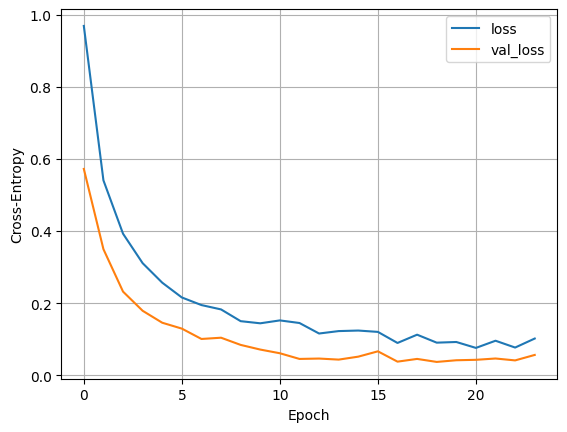

In [ ]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.grid(True)

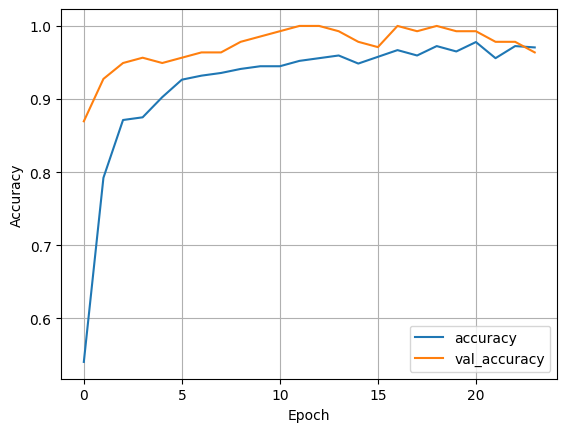

In [ ]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [ ]:
# Making predictions for the test set
test_probs: np.array = model.predict(val_ds)
# Converting probabilities into specific predictions
test_preds: np.array = np.argmax(test_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 882ms/step


In [ ]:
# Extracting y_test

# Unpack batch labels from val_ds
y_test_batches: list[np.ndarray] = [y for x, y in val_ds]
# Concatonate batches
y_test: np.ndarray = np.concatenate(y_test_batches)

In [ ]:
# Examining scores
class_names: list[str] = ['A', 'B', 'C']

print(classification_report(y_test, test_preds, target_names=class_names))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        53
           B       1.00      1.00      1.00        40
           C       1.00      1.00      1.00        45

    accuracy                           1.00       138
   macro avg       1.00      1.00      1.00       138
weighted avg       1.00      1.00      1.00       138



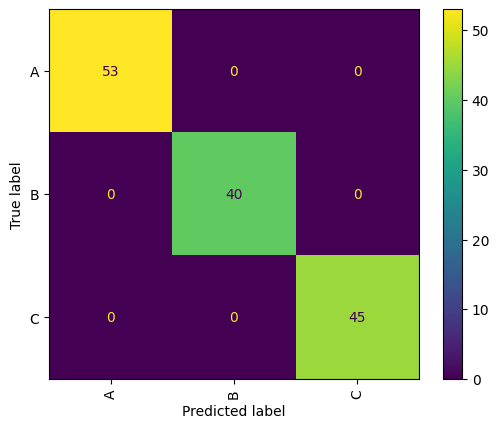

In [ ]:
# Displaying confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=test_preds,
    display_labels=class_names,
    xticks_rotation='vertical'
);

Let's take a look at some of it's predictions

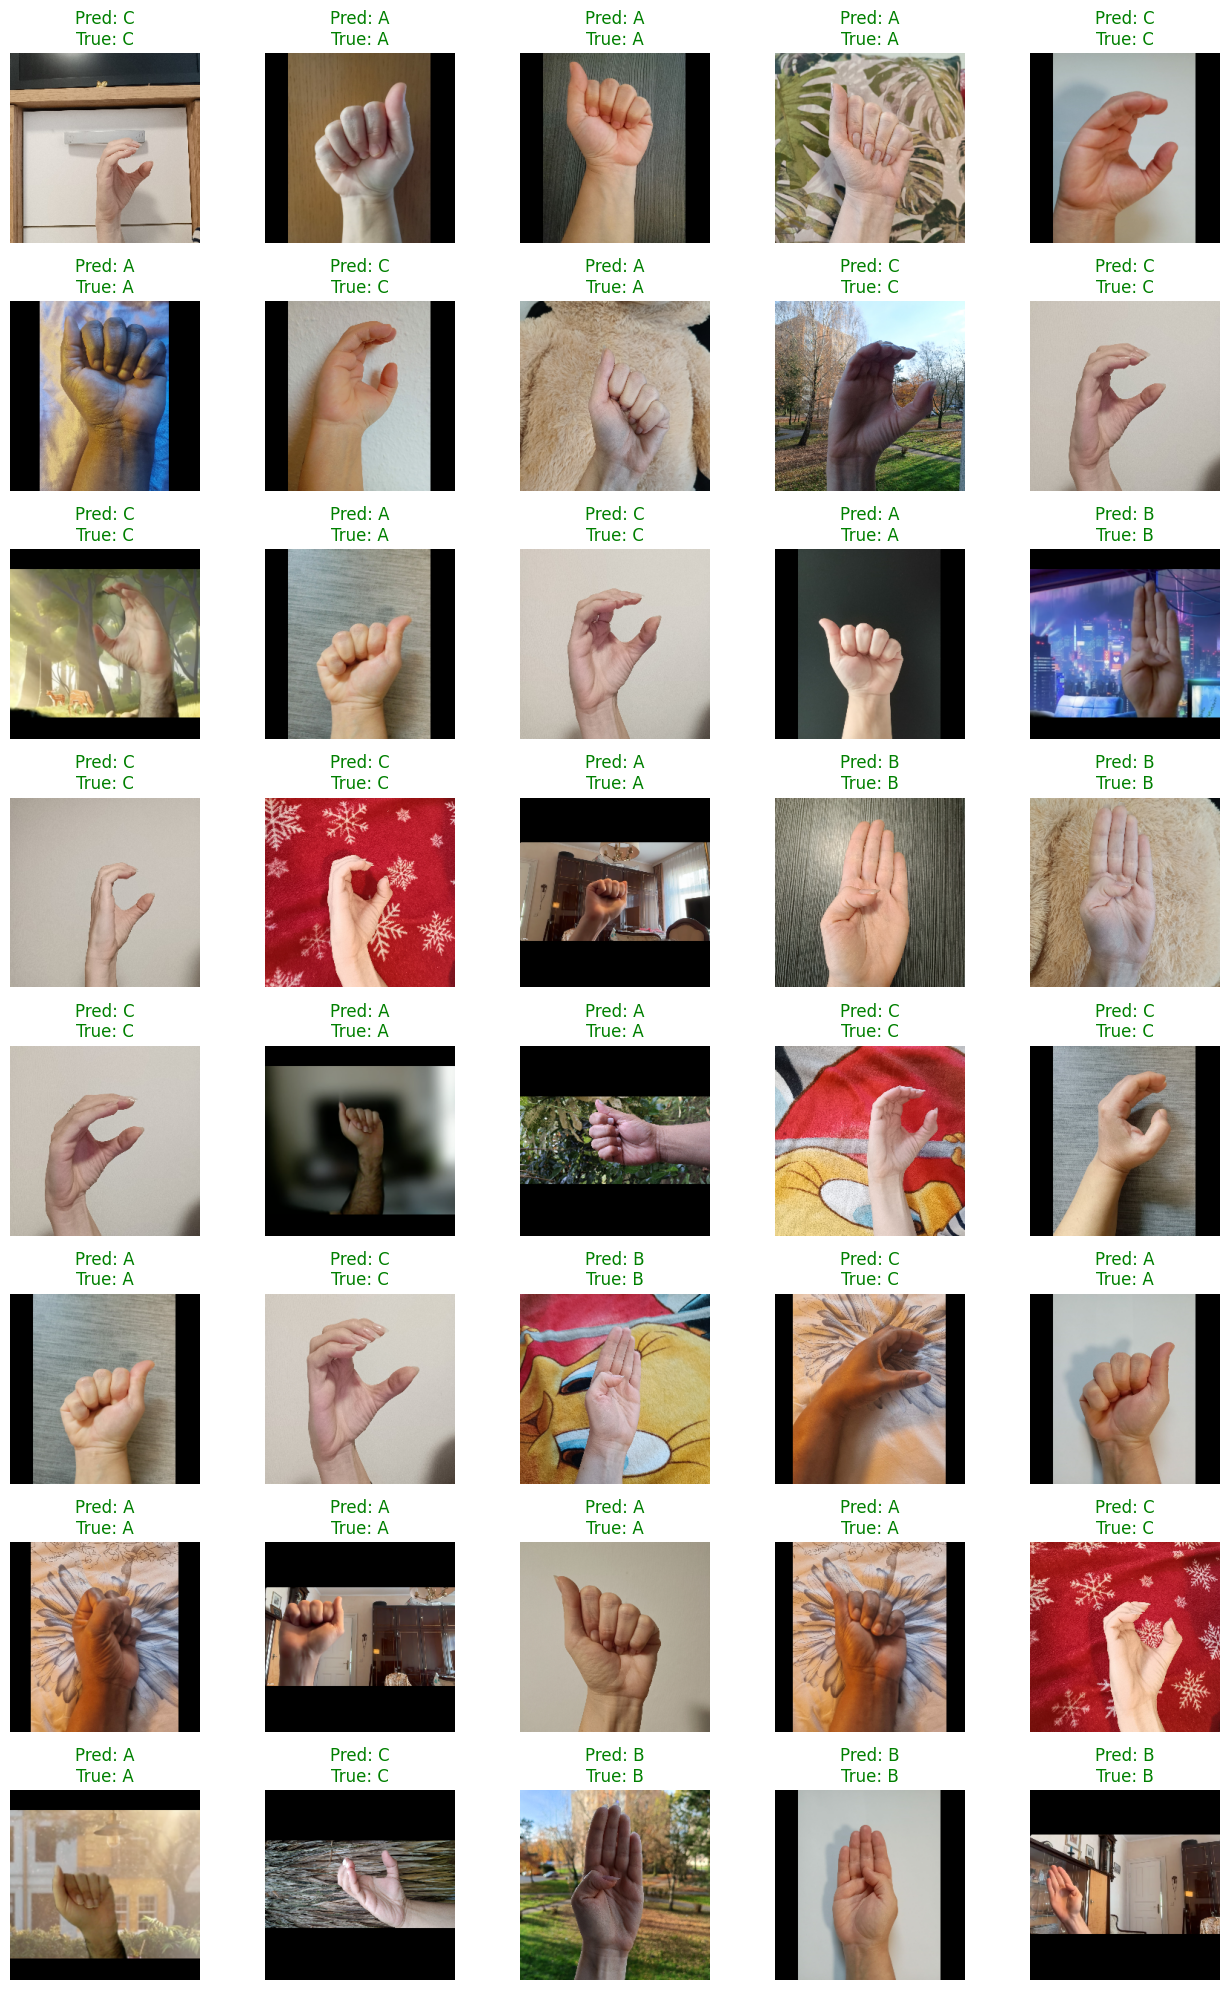

In [ ]:
# Visualizing first 40 predictions
num_vis: int = 40

# Extracting images
batched_test_images: list[np.ndarray] = [X_batch for X_batch, y_batch in val_ds]
test_images: np.ndarray = np.concatenate(batched_test_images)

plt.figure(figsize=(int(num_vis/3),int(num_vis/2)))
columns=5

for i in range(num_vis):
    plt.subplot(int(num_vis/columns), columns, i+1)
    plt.imshow(test_images[i].astype('uint8'), cmap='gray')
    pred: int = test_preds[i]
    true: int = y_test[i]
    colour = 'green' if pred == true else 'red'
    plt.title(f'Pred: {class_names[pred]}\nTrue: {class_names[true]}', color=colour)
    plt.axis('off')

plt.tight_layout()
plt.show()